# LAB 03.01 - Model Generation

In [3]:
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/rramosp/ai4eng.v1/main/content/init.py
import init; init.init(force_download=False); init.get_weblink()
init.endpoint

replicating local resources


'https://m5knaekxo6.execute-api.us-west-2.amazonaws.com/dev-v0001/rlxmooc'

In [4]:
from local.lib.rlxmoocapi import submit, session
session.LoginSequence(endpoint=init.endpoint, course_id=init.course_id, lab_id="L03.01", varname="student");

logging in as guillermo.naranjo@udea.edu.co ... please wait

-------------
using course session ai4eng.v1.udea.r3::2025.1
success!! you are logged in
-------------


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from local.lib import mlutils
from IPython.display import Image
%matplotlib inline

## A machine learning task

We have two species of bugs (**X bugs** and **Z bugs**), for each bug we have measured its **width** and **length**. Once we have a bug, determining if is of  **species X** or **species Z** is very costly (lab analysis, etc.)

**Machine learning goal**: We want to create a model so that, when given the width and length of a bug, will tell us whether it belongs to  **species X** or **species Z**. If the model performs well, we might use it insted of the lab analysis.

**To train a machine learning model** we built a **training dataset** where we have **annotated** 20 bugs with their **confirmed** species. The training dataset has:

- 20 data items
- two data columns (**width** and **length**)
- one label column, with two unique values: **0 for species X**, and **1 for species Z**.


In [6]:

d = pd.read_csv("local/data/trilotropicos_small.csv")
X,y = d.values[:,:2], d.values[:,-1]
print (d.shape, X.shape, y.shape)
print (X[:5])
print (y[:5])
d.head()


(20, 3) (20, 2) (20,)
[[0.5  0.65]
 [0.75 0.34]
 [0.37 0.5 ]
 [0.57 0.74]
 [1.   0.69]]
[0. 1. 1. 0. 1.]


,width,height,y
0,0.50,0.65,0.0
1,0.75,0.34,1.0
2,0.37,0.50,1.0
3,0.57,0.74,0.0
4,1.00,0.69,1.0


Since it is just two columns, we can visualize it

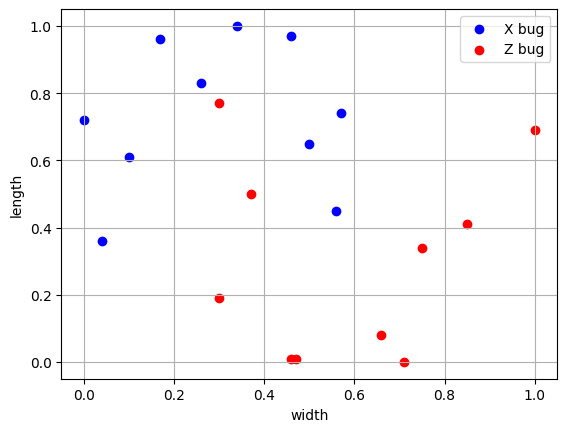

In [7]:

plt.scatter(X[y==0][:,0], X[y==0][:,1], color="blue", label="X bug")
plt.scatter(X[y==1][:,0], X[y==1][:,1], color="red", label="Z bug")
plt.xlabel("width");plt.ylabel("length"); plt.legend(); plt.grid();


## Task 1. Manually use a predictive model

We give you a procedure somewhat calibrated so that, given a new bug, it produces a prediction. The procedure depends on two parameters $\theta_0$ and $\theta_1$. Given the width $w^{(i)}$ and height $h^{(i)}$ of bug number $i$, the prediction $\hat{y}^{(i)} \in \{0, 1\}$ is computed as follows:

$$\hat{y}^{(i)} = 0\text{ if }w^{(i)}<\theta_0\text{ AND }h^{(i)}>\theta_1;\;\;\;\;\;\text{otherwise }\hat{y}^{(i)}=1$$


This can be considered as a **model template**, depending on two parameters.


Complete **the following function** so that whenever given a `numpy` array `X` $\in \mathbb{R}^m \times \mathbb{R}^2$ containing the width and height of $m$ bugs, returns a vector $\in \mathbb{R}^m$ with the predictions of the $m$ bugs as described in the expression above. The parameter `t` $\in \mathbb{R}^2$ contains, in this order, $\theta_0$ and $\theta_1$

Observe that your function must return a `numpy` vector of **integers** (not booleans).

**CHALLENGE**: solve it with one single line of code

**HINT**: use `.astype(int)` to convert a `numpy` array of booleans to integers.

In [8]:


def predict(X, t):
    """
    Predice la especie de los insectos según su ancho y largo.

    Parámetros:
    X : ndarray, forma (n, 2)
        Matriz con las características de los insectos (ancho y largo).
    t : ndarray, forma (2,)
        Vector con los umbrales para ancho y largo.

    Retorno:
    y_pred : ndarray
        Vector con las predicciones (0 para especie X, 1 para especie Z).
    """
    return (X[:, 0] > t[0]) | (X[:, 1] > t[1])  # Clasificación


check manually your code, your predictions with the following `t` must be

       [1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0]
       
with an accuracy of 0.75

In [ ]:
t = np.arrayr_[.5,.3]
y_hat = predict(X, t)
y_hat

In [ ]:

accuracy = np.mean(y == y_hat)

print("Predicciones:", y_hat)
print("Precisión:", accuracy)


observe the classification boundary that the model generates

In [ ]:
mlutils.plot_2Ddata_with_boundary(lambda X: predict(X,t), X, y); plt.grid();

and with other `t` ... which is better?

In [ ]:
t = np.r_[.5,.8]
mlutils.plot_2Ddata_with_boundary(lambda X: predict(X,t), X, y); plt.grid();
np.mean(y==predict(X,t))

observe the prediction boundaries of other models. Change the `max_depth` of the decision tree to 2. Does it look familiar?

In [ ]:
from sklearn.linear_model import LogisticRegression
mlutils.plot_2Ddata_with_boundary(LogisticRegression().fit(X,y).predict, X, y); plt.grid();

In [ ]:
from sklearn.tree import DecisionTreeClassifier
mlutils.plot_2Ddata_with_boundary(DecisionTreeClassifier(max_depth=5).fit(X,y).predict, X, y); plt.grid();

In [ ]:
from sklearn.svm import SVC
mlutils.plot_2Ddata_with_boundary(SVC(gamma=50).fit(X,y).predict, X, y); plt.grid();

**submit your answer**

In [ ]:
student.submit_task(globals(), task_id="task_01");

## Task 2. Fit the model

Given a set of annotated data $X$, $y$ and the **model template** of the previous exercise, complete the following function that returns $\theta_0$ and $\theta_1$ that produce the **best accuracy** on the given `X` and `y`. Consider only $\theta_0$ and $\theta_1$ with **one decimal number between 0 and 1**.

**Hint**: use a brute force approach, consider all combinations of $\theta_0$ and $\theta_1 \in$ [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]. Use [`np.linspace`](https://numpy.org/doc/stable/reference/generated/numpy.linspace.html) and [`itertools.product`](https://docs.python.org/3/library/itertools.html#itertools.product)

Your function must return an `numpy` array with two elements, the resulting $\theta_0$ and $\theta_1$

In [ ]:
import itertools


def fit(X,y):
    def predict(X, t):
        return ...

    return ...

In [ ]:
t = fit(X,y)

Check your solution with the code below. The `t` returned by your function should produce an accuracy of 0.9 with the example data `X`, `y`. There might be several `t` producing the same accuracy, you just have to return any of those.

In [ ]:
mlutils.plot_2Ddata_with_boundary(lambda X: predict(X,t), X, y); plt.grid();
np.mean(y==predict(X,t))

you can also use your model on different data. Execute the next cells several times to see the effect on different datasets.

In [ ]:
from sklearn.datasets import make_blobs
from sklearn.preprocessing import MinMaxScaler

bX, by = make_blobs(100,n_features=2, centers=2)
bX = MinMaxScaler(feature_range=(0.1,.9)).fit_transform(bX)

In [ ]:
bt = fit(bX, by)

In [ ]:
mlutils.plot_2Ddata_with_boundary(lambda X: predict(X,bt), bX, by); plt.grid();
np.mean(by==predict(bX,bt))

**submit your answer**

In [ ]:
student.submit_task(globals(), task_id="task_02");

## Task 3: Make an `sklearn` compatible class with your model

organize the previous methods in the following class structure. Bear in mind that:

- the `fit` method now does not return `t`, which is now stored in an instance variable `self.t`
- the `fit` method must now return `self`.
- the `predict` method now does not accept `t` as argument, it must use the one stored in `self.t`

In [ ]:
def SimpleModel():
    class _SimpleModel:

        def __init__(self):
            pass

        def fit(self, X, y):

            ....
            return self

        def predict(self, X):
            return ....

    return _SimpleModel()

In [ ]:
m = SimpleModel()
m.fit(X,y)
m.predict(X)

In [ ]:
mlutils.plot_2Ddata_with_boundary(m.predict, X, y); plt.grid();
np.mean(y==m.predict(X))

check your model with different parametrizations of the `moons` dataset (more and less data points, more and less noise)

In [ ]:
from sklearn.datasets import make_moons

mX, my = make_moons(100, noise=.1)
m = SimpleModel()
m.fit(mX,my)

mlutils.plot_2Ddata_with_boundary(m.predict, mX, my); plt.grid();
np.mean(my==m.predict(mX))

**submit your answer**

In [ ]:
student.submit_task(globals(), task_id="task_03");